In [1]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import numpy as np

import torchvision

from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import time

import os

import copy



mean = np.array([0.5, 0.5, 0.5])

std = np.array([0.25, 0.25, 0.25])



data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(224),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

}

In [ ]:
data_dir = '/home/foe_stu/Documents/DATA/trainPhase1'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

                                          data_transforms[x])

                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,

                                             shuffle=True, num_workers=0)

              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)





def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()



['Obs', 'def', 'nor']


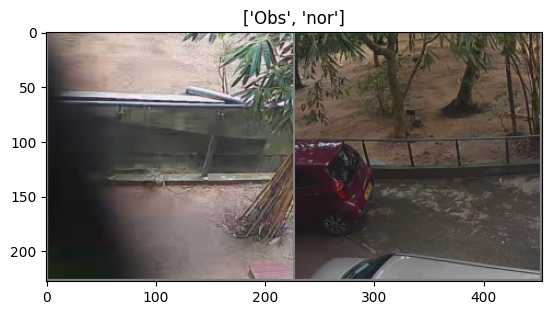

In [3]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))



# Make a grid from batch

out = torchvision.utils.make_grid(inputs)



imshow(out, title=[class_names[x] for x in classes])



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0



    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        print('-' * 10)



        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:

            if phase == 'train':

                model.train()  # Set model to training mode

            else:

                model.eval()   # Set model to evaluate mode



            running_loss = 0.0

            running_corrects = 0



            # Iterate over data.

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)

                labels = labels.to(device)



                # forward

                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)



                    # backward + optimize only if in training phase

                    if phase == 'train':

                        optimizer.zero_grad()

                        loss.backward()

                        optimizer.step()



                # statistics

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)



            if phase == 'train':

                scheduler.step()



            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(

                phase, epoch_loss, epoch_acc))
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)



            # deep copy the model

            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)



        print()



    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(

        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))



    # load best model weights

    model.load_state_dict(best_model_wts)

    return model



In [4]:
model = models.mobilenet_v2(pretrained=True)
num_classes = 3

# Replace the final classifier with a new one
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2),  # Add dropout if needed
    torch.nn.Linear(model.last_channel, num_classes),
)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



In [7]:


model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)



Epoch 0/19
----------
train Loss: 0.8118 Acc: 0.6285
val Loss: 0.4469 Acc: 0.8258

Epoch 1/19
----------
train Loss: 0.6972 Acc: 0.7134
val Loss: 0.5464 Acc: 0.7669

Epoch 2/19
----------
train Loss: 0.6651 Acc: 0.7289
val Loss: 0.4058 Acc: 0.8785

Epoch 3/19
----------
train Loss: 0.6190 Acc: 0.7476
val Loss: 0.5186 Acc: 0.7914

Epoch 4/19
----------
train Loss: 0.6034 Acc: 0.7478
val Loss: 0.3698 Acc: 0.8454

Epoch 5/19
----------
train Loss: 0.6015 Acc: 0.7494
val Loss: 0.2682 Acc: 0.8933

Epoch 6/19
----------
train Loss: 0.5904 Acc: 0.7470
val Loss: 0.3620 Acc: 0.8748

Epoch 7/19
----------
train Loss: 0.5290 Acc: 0.7815
val Loss: 0.2417 Acc: 0.9080

Epoch 8/19
----------
train Loss: 0.5258 Acc: 0.7818
val Loss: 0.3016 Acc: 0.8810

Epoch 9/19
----------
train Loss: 0.5179 Acc: 0.7762
val Loss: 0.2881 Acc: 0.8908

Epoch 10/19
----------
train Loss: 0.5210 Acc: 0.7857
val Loss: 0.3705 Acc: 0.8675

Epoch 11/19
----------
train Loss: 0.5143 Acc: 0.7799
val Loss: 0.2311 Acc: 0.9018

Ep

In [8]:
# Assuming 'model' is your PyTorch model

torch.save(model.state_dict(), 'mobilenet.pth')

torch.save(optimizer.state_dict(), "mobilenetoptim.pth")


(0.6284512227189062, 0.8257668711656442, 0.713384170391796, 0.7668711656441718, 0.728898238232974, 0.8785276073619632, 0.7475677097028662, 0.7914110429447854, 0.747830660005259, 0.845398773006135, 0.7494083618196161, 0.8932515337423313, 0.7470418090980805, 0.8748466257668712, 0.7814882987115436, 0.9079754601226995, 0.7817512490139364, 0.8809815950920246, 0.7762292926636866, 0.89079754601227, 0.7856955035498291, 0.8674846625766872, 0.7799105968971864, 0.901840490797546, 0.7930581120168289, 0.89079754601227, 0.7888509071785433, 0.9006134969325154, 0.7998948198790429, 0.898159509202454, 0.7793846962924008, 0.8834355828220859, 0.7896397580857218, 0.8760736196319019, 0.7864843544570077, 0.8441717791411043, 0.7938469629240074, 0.8797546012269939, 0.7896397580857218, 0.8883435582822087)
(0.8117809979881295, 0.6971885758933819, 0.6650658804945826, 0.6189757866053684, 0.6034204464164802, 0.6014626291214386, 0.5903779396328359, 0.5290062636266312, 0.5258103573590501, 0.5179112279621623, 0.521048

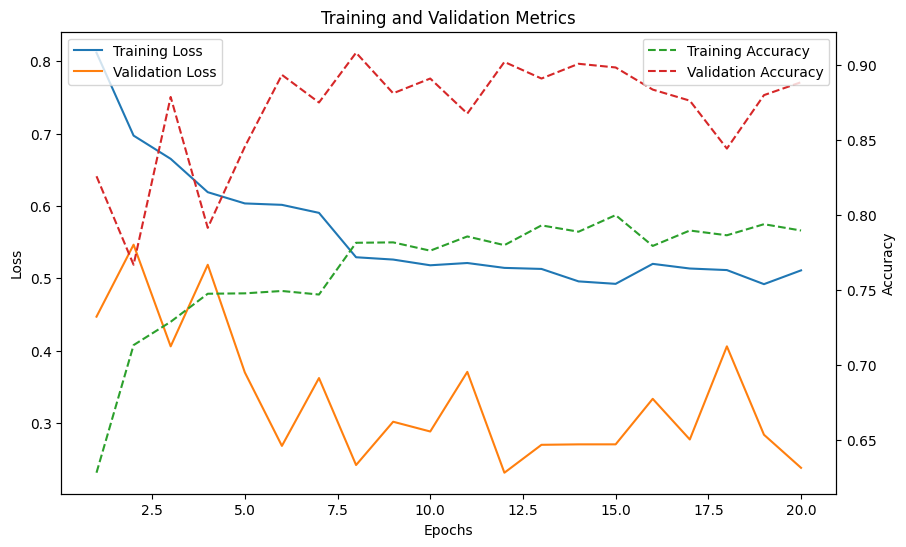

In [10]:
tensor_tuple = train_acc

# Extract the first element of each tensor in the tuple
float_tuple = tuple(tensor.item() for tensor in tensor_tuple)

# Print the float tuple
print(float_tuple)


def separate_even_odd_indexes(float_tuple):
  train_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 == 0)
  valid_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 != 0)
  return train_accuracy, valid_accuracy

#test_tup = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
train_accuracyy, valid_accuracyy = separate_even_odd_indexes(float_tuple)


#Losses
def separate_even_odd_indexes(train_loss):
  trainig_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 == 0)
  val_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 != 0)
  return trainig_loss, val_loss

#test_tup = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
trainig_loss, val_loss = separate_even_odd_indexes(train_loss)

print(trainig_loss)
print(val_loss)

import matplotlib.pyplot as plt




# Sample data (replace with your actual data)

epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_losses = trainig_loss

val_losses = val_loss

train_accuracies = train_accuracyy

val_accuracies = valid_accuracyy



fig, ax1 = plt.subplots(figsize=(10, 6))



# Plot training and validation losses on the primary y-axis (left)

ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')

ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')

ax1.set_xlabel('Epochs')

ax1.set_ylabel('Loss', color='black')

ax1.tick_params(axis='y', labelcolor='black')

ax1.legend(loc='upper left')



# Create a secondary y-axis (right) for accuracy

ax2 = ax1.twinx()



# Plot training and validation accuracies on the secondary y-axis (right)

ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')

ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')

ax2.set_ylabel('Accuracy', color='black')

ax2.tick_params(axis='y', labelcolor='black')

ax2.legend(loc='upper right')



plt.title('Training and Validation Metrics')

plt.xlabel('Epochs')



# Show the combined plot

plt.show()

In [11]:
from PIL import Image, ImageDraw, ImageFont
model.eval()

# Define the data transformation for the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Make sure 'mean' and 'std' are defined
])

# Define the input and output folders
input_folder = '/home/foe_stu/Documents/DATA/Test data'  # Replace with the path to your input image folder
output_folder = '/home/foe_stu/Documents/DATA/trainPhase1/TestMobilenet/'  # Replace with the path to your output image folder

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

# Loop through the images in the input folder
for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_folder, image_file)
    image = Image.open(image_path)

    # Apply the transformation to the image
    input_tensor = transform(image)

    # Add batch dimension to the input tensor (model expects a batch of images)
    input_batch = input_tensor.unsqueeze(0)

    # Move the input tensor to the same device as the model (CPU or GPU)
    input_batch = input_batch.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_class = torch.max(output, 1)

    # Map the class index to the class name
    predicted_class_name = class_names[predicted_class]

    # Create a drawing context on the image
    draw = ImageDraw.Draw(image)

    # Define the font and size for the text
    font = ImageFont.truetype("//home//foe_stu//Downloads//fonts//arial//arial.ttf", 36)  # Replace with the path to your font file

    # Define the position and color for the text
    text_position = (20, 20)  # Adjust the position as needed
    text_color = (255, 0, 0)  # Red color

    # Draw the predicted class label on the image
    draw.text(text_position, f"Predicted Class: {predicted_class_name}", fill=text_color, font=font)

    # Save the modified image to the output folder
    output_image_path = os.path.join(output_folder, image_file)
    image.save(output_image_path)

# Optionally, you can display or further process the modified images as needed.